In [19]:
###Matching Fermi-GBM and Swift Data###
import pandas as pd
import math
import gc
import julian
import numpy as np
from astropy.time import Time
import scipy.stats as st
import re
import datetime
from statistics import NormalDist
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pdb
import scipy.integrate as integrate

In [21]:
##Data import##
fermi_data=pd.read_csv('22_May_2023_Fermi_Data.csv')
swift_data=pd.read_csv('real swift bat data 2.csv')
swift_fluxes=pd.read_csv('swift_fluxes_2.csv')
swift_fluences_PL=pd.read_csv('swift_fluences_3_PL.csv')
swift_fluences_CPL=pd.read_csv('swift_fluences_3_PL.csv')
swift_fluences_reference=pd.read_csv('swift_fluences_3_match.csv')
swift_redshifts=pd.read_csv('swift_redshifts.csv')
second_redshifts=pd.read_csv("changed_alternative_GCN_redshifts.csv")
more_xrt_data=pd.read_csv('XRT_most_detailed_data.csv')

In [89]:
#God forbid I actually define a function#
def singly_broken_PL(amplitude, break1, power1, power2, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1:
        value=amplitude*t**(power2)*break1**(power1-power2)
    else:
        value='N/A'
    return value

def doubly_broken_PL(amplitude, break1, break2, power1, power2, power3, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    else:
        value='N/A'
    return value

def triply_broken_PL(amplitude, break1, break2, break3, power1, power2, power3, power4, t0,\
                     t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    else:
        value='N/A'
    return value

def quadruply_broken_PL(amplitude, break1, break2, break3, break4, power1, power2, power3,\
                        power4, power5, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    else:
        value='N/A'
    return value

def quintuply_broken_PL(amplitude, break1, break2, break3, break4, break5, power1, power2,\
                        power3, power4, power5, power6, t0, t):
    if t<break1 and t>t0:
        value=amplitude*t**(power1)
    elif t>=break1 and t<break2:
        value=amplitude*t**(power2)*break1**(power1-power2)
    elif t>=break2 and t<break3:
        value=amplitude*t**(power3)*break1**(power1-power2)*break2**(power2-power3)
    elif t>=break3 and t<break4:
        value=amplitude*t**(power4)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)
    elif t>=break4 and t<break5:
        value=amplitude*t**(power5)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)
    elif t>=break5:
        value=amplitude*t**(power6)*break1**(power1-power2)*break2**(power2-power3)*\
                              break3**(power3-power4)*break4**(power4-power5)*\
                                break5**(power5-power6)
    else:
        value='N/A'
    return value

def defining_the_flux(tarjit, temporal_indices):
    flux_catch=' Obs Flux_{} (pc) '.format(tarjit+1)
    tarjete=tarjit+1
    xrt_flux=more_xrt_data[flux_catch][xrt_match]
    state=0
    if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
        flux_catch=' Obs Flux_{} (wt) '.format(tarjit+1)
        xrt_flux=more_xrt_data[flux_catch][xrt_match]
        state=1
        #weird case where sometimes XRT is still repointing or something, IDK.
        #It nets us 220101A, which is what I wanted.
    if tarjit==0:
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            flux_catch=' Obs Flux_{} (pc) '.format(tarjit+2)
            xrt_flux=more_xrt_data[flux_catch][xrt_match]
            tarjete=tarjit+2
            state=0
            if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
                flux_catch=' Obs Flux_{} (wt) '.format(tarjit+2)
                xrt_flux=more_xrt_data[flux_catch][xrt_match]
                state=1
                #weird case where if it's at the very beginning, XRT
                #might not be measuring flux yet
    return flux_catch, xrt_flux, tarjete, state

def HR_err_func(S_top, S_bot, sig_S_top, sig_S_bot):
    HR_err=np.sqrt(np.power((sig_S_top/S_bot), 2)+np.power((S_top*sig_S_bot)/\
                                                          np.power(S_bot,2), 2))
    return HR_err

def Fermi_HR_func(relevant_fermi_data, spectral_model, entry):
    low_e_range=[15, 150]
    high_e_range=[150, 1500]
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
        low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                              low_e_range[1]) #PL
        high_HR=integrate.quad(lambda x: power_law(x, p_1), high_e_range[0], \
                              high_e_range[1]) #PL
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_comp_index'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        low_HR=integrate.quad(lambda x:  Compton_PL(x, p_1, E_break), \
                       low_e_range[0], low_e_range[1]) #CPL
        high_HR=integrate.quad(lambda x: Compton_PL(x, p_1, E_break), \
                       high_e_range[0], high_e_range[1]) #CPL
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_band_alpha'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_band_beta'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        low_HR=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       low_e_range[0], low_e_range[1]) #Band
        high_HR=integrate.quad(lambda x: Band_function(x, E_break, p_1, p_2), \
                       high_e_range[0], high_e_range[1]) #Band
        HR=high_HR[0]/low_HR[0]
        
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        p_1=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx1'])
        p_2=float(relevant_fermi_data.at[entry, 'flnc_sbpl_indx2'])
        E_break=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
        smoothen=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brksc'])
        low_HR=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen), \
                       low_e_range[0], low_e_range[1])
        high_HR=integrate.quad(lambda x: Smoothly_Broken_PL(x, E_break, p_1, p_2, smoothen),\
                       high_e_range[0], high_e_range[1])
        HR=high_HR[0]/low_HR[0]
        
    else:
        if relevant_fermi_data.at[entry, 'flnc_plaw_index']:
            p_1=float(relevant_fermi_data.at[entry, 'flnc_plaw_index'])
            low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
                                  low_e_range[1])
            high_HR=integrate.quad(lambda x: power_law(x, p_1), \
                               high_e_range[0], high_e_range[1]) 
            #PL because that's the simplest one, unfortunately
            HR=high_HR[0]/low_HR[0]
        else:
            HR=np.NA
    return HR

def swift_error_calculator(entry, fluence_table):
    if fluence_table.at[entry, ' 50_100kev_low '] != ' N/A ':
         HR_err_left = HR_err_func(float(fluence_table.at[entry, ' 50_100kev ']), \
                                float(fluence_table.at[entry, ' 25_50kev ']), \
                                float(fluence_table.at[entry,' 50_100kev_low ']), \
                                float(fluence_table.at[entry,' 25_50kev_low ']))
#         HR_err_left = (float(fluence_table.at[entry,' 50_100kev '])-\
#                         float(fluence_table.at[entry, ' 50_100kev_low ']))/\
#                             (float(fluence_table.at[entry, ' 25_50kev '])-\
#                                    float(fluence_table.at[entry,' 25_50kev_low ']))
    else:
        HR_err_left = 0
    if fluence_table.at[entry, ' 50_100kev_hi '] != ' N/A ':
         HR_err_right=HR_err_func(float(fluence_table.at[entry, ' 50_100kev ']),\
                                 float(fluence_table.at[entry, ' 25_50kev ']), \
                                 float(fluence_table.at[entry,' 50_100kev_hi ']), \
                             float(fluence_table.at[entry,' 25_50kev_hi ']))
#         HR_err_right = (float(fluence_table.at[entry, ' 50_100kev '])-\
#                         float(fluence_table.at[entry, ' 50_100kev_hi ']))/\
#                             (float(fluence_table.at[entry, ' 25_50kev '])-\
#                                    float(fluence_table.at[entry, ' 25_50kev_hi ']))
    else:
        HR_err_right = 0
    return [HR_err_left, HR_err_right]

def power_law (variable, index):
    value=variable**index
    return value

def Compton_PL (variable, index, break_E):
    value=np.power(variable, index)*np.exp(-variable/break_E)
    return value

def Band_function (variable, break_E, index_1, index_2):
    if variable < ((index_1-index_2)*break_E)/(index_1+2):
        value=((variable/100)**index_2)*np.exp(index_2-index_1)*(((index_1-index_2)*\
                                    break_E)/(100*(index_1+2)))**(index_1-index_2)
    elif variable >= ((index_1-index_2)*break_E)/(index_1+2):
        value= ((variable/100)**index_1)*np.exp(-((index_1+2)*variable)/break_E)
    else:
        value=np.NaN
    return value

def Smoothly_Broken_PL (variable, break_E, index_1, index_2, smoothen):
    value=(variable/break_E)**(index_1)*(0.5*(1+(variable/break_E)**(1/smoothen)))**\
    (-(index_1-index_2)/smoothen)
    return value

def swift_fluence_function(burst_index, column_name):
    if swift_fluences_reference.at[burst_index, ' Best-fit model']==' PL':
        fluence=swift_fluences_PL.at[burst_index, column_name]
    elif swift_fluences_reference.at[burst_index, ' Best-fit model']==' CPL':
        fluence=swift_fluences_CPL.at[burst_index, column_name]
    else:
        fluence=np.NaN
    return fluence

def getting_the_GBM_E_peak(relevant_fermi_data, spectral_model, entry):
    if spectral_model=='flnc_plaw              ' or spectral_model==1:
        if relevant_fermi_data.at[entry, 'flnc_comp_epeak']:
            E_peak=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
        elif relevant_fermi_data.at[entry, 'flnc_band_epeak']:
            E_peak=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
        else:
            E_peak=np.NaN
    elif spectral_model=='flnc_comp              ' or spectral_model==2:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_comp_epeak'])
    elif spectral_model=='flnc_band              ' or spectral_model==3:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_band_epeak'])
    elif spectral_model=='flnc_sbpl              ' or spectral_model==4:
        E_peak=float(relevant_fermi_data.at[entry, 'flnc_sbpl_brken'])
    else:
        E_peak=np.NaN
    return E_peak

In [34]:
#Yeah, this dictionary will make life 500x easier later
Known_Precursors = {}
Known_Precursors["Long Collapsars"] = ('GRB050416A   ', 'GRB081007   ', 'GRB091127   ', \
                                       'GRB050525A   ', 'GRB050824   ', 'GRB060218   ', \
                                       'GRB060729   ', 'GRB060904B   ', 'GRB070419A   ', \
                                       'GRB071025   ', 'GRB071112C   ', 'GRB080109   ', \
                                       'GRB080319B   ', 'GRB081007A   ', 'GRB090618   ', \
                                       'GRB091127   ', 'GRB100316D   ', 'GRB100418A   ', \
                                       'GRB101219B   ', 'GRB101225A   ', 'GRB111209A   ', \
                                       'GRB111211A   ', 'GRB111228A   ', 'GRB120422A   ', \
                                       'GRB120714B   ', 'GRB120729A   ', 'GRB130215A   ', \
                                       'GRB130427A   ', 'GRB130702A   ', 'GRB130831A   ', \
                                       'GRB140206A   ', 'GRB140606B   ', 'GRB150818A   '\
                                       'GRB161219B   ', 'GRB161228B   ', 'GRB171010A   ', \
                                       'GRB171205A   ', 'GRB180720B   ', 'GRB180728A   ', \
                                       'GRB190114C   ', 'GRB190829A   ', 'GRB221009A   ', \
                                       'GRB211023A   ', 'GRB200826A   ', 'GRB210210A   ')
Known_Precursors["Short Collapsars"] = ('GRB200826A   ')
Known_Precursors["Short Mergers"] = ('GRB130603B   ', 'GRB160821B   ', 'GRB200522A   ', \
                                     'GRB150101B   ', 'GRB160624A   ', 'GRB170817A   ', \
                                     'GRB070809   ')
Known_Precursors["Long Mergers"] = ('GRB211211A   ', 'GRB230307A   ', 'GRB120304B   ', \
                                    'GRB111005A   ', 'GRB060614   ')
Known_Precursors["Potentially Exotic"] = ("GRB 210704A   ")
###
Fermi_Precursors = {}
Fermi_Precursors["Long Collapsars"] = ('GRB050416461', 'GRB050525002', 'GRB050824966', \
                                       'GRB060218148', 'GRB060729800', 'GRB060904104', \
                                       'GRB070419447', 'GRB071025172', 'GRB071112772', \
                                       'GRB080319258', 'GRB081007224', 'GRB090618353', \
                                       'GRB091127976', 'GRB100316531', 'GRB100418882', \
                                       'GRB101219686', 'GRB101225776', 'GRB111209300', \
                                       'GRB111211928', 'GRB111228656', 'GRB120422300', \
                                       'GRB120714888', 'GRB120729455', 'GRB130215063', \
                                       'GRB130427324', 'GRB130702003', 'GRB130831544', \
                                       'GRB140206303', 'GRB140606133', 'GRB150818483', \
                                       'GRB161219783', 'GRB161228552' ,'GRB171010792', \
                                       'GRB171205306', 'GRB180720598', 'GRB180728728', \
                                       'GRB190114872', 'GRB190829830', 'GRB200826187', \
                                       'GRB210210083', 'GRB211023545', 'GRB221009553')
Fermi_Precursors["Short Collapsars"] = ('GRB200826187')
Fermi_Precursors["Short Mergers"] = ('GRB070809807', 'GRB130603659', 'GRB150101641', \
                                     'GRB160624477', 'GRB160821936', 'GRB170817528', \
                                     'GRB200522487')
Fermi_Precursors["Long Mergers"] = ('GRB060614530', 'GRB111005336', 'GRB120304248', \
                                    'GRB211211548', 'GRB230307655')
Fermi_Precursors["Potentially Exotic"] = ('GRB210704814')

In [51]:
##Creating Sample 0##
tiny_removals=[]
singular_swift_fluences_list=np.zeros((1,8))
tarjete=0
stage=0
for i in range(0,len(swift_fluences_reference)):
    #for each event
    placeholder=[[swift_data.at[i, 'GRBname '], swift_fluence_function(i, ' 25_50kev '), \
                swift_fluence_function(i, ' 25_50kev_low '), \
                swift_fluence_function(i, ' 25_50kev_hi '), \
                swift_fluence_function(i, ' 50_100kev '),\
                                          swift_fluence_function(i, ' 50_100kev_low '),\
                                          swift_fluence_function(i, ' 50_100kev_hi '), 
                                          swift_fluence_function(i, ' 15_350kev ')]]
    singular_swift_fluences_list=np.append(singular_swift_fluences_list, \
                placeholder, axis=0)
    test_flux=swift_fluxes.at[i,' 15_350kev ']
    test_direction=swift_data['  RA_ground   '][i]
    test_time=swift_data['     T90      '][i]
    if test_direction==' N/A ' or test_direction=='N/A':
            tiny_removals.append(i)
    elif test_time==' N/A ' or test_time=='N/A':
            tiny_removals.append(i)
    elif test_flux==' N/A ':
            tiny_removals.append(i)
if (len(swift_fluxes)-1)<(len(swift_data)-1):
    for k in range(len(swift_fluxes)-1, len(swift_data)):
        tiny_removals.append(k)
singular_swift_fluences_list=singular_swift_fluences_list[1:]
swift_fluences=pd.DataFrame(singular_swift_fluences_list, columns=['GRBname ', ' 25_50kev ',\
                                                                  ' 25_50kev_low ', \
                                                                   ' 25_50kev_hi ', \
                                                                   ' 50_100kev ', \
                                                                   ' 50_100kev_low ', \
                                                                   ' 50_100kev_hi ', ' 15_350kev '])
sample_0_data = swift_data.drop(index=tiny_removals)
print(len(sample_0_data))
print(len(swift_fluences))
print(len(swift_data))

1371
1525
1527


In [52]:
##Creating Samples 1 and 4##
removals=[]
xrt_matches=np.zeros((1,2))
xrt_stages=np.zeros((1,2))
xrt_avg_slope=np.zeros((1,2))
tarjete=0
stage=0
for i in range(0,len(swift_fluxes)):
    #for each event
    query=swift_data[' XRT_detection '][i]
    #query the XRT detection then add it to the first empty list
    #print(swift_fluxes.at[i,' 15_350kev '])
    test_flux=swift_fluxes.at[i,' 15_350kev ']
    test_direction=swift_data['  RA_ground   '][i]
    test_time=swift_data['     T90      '][i]
    #snap=swift_data['GRBname '][i].strip()[3:]
    #pdb.set_trace()
    if len(np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0])>0:
#         if swift_data['GRBname '][i].strip()[3:]=='211211A':
#             pdb.set_trace()
        xrt_match=np.where(swift_data['GRBname '][i].strip()[3:]==more_xrt_data['GRB '])[0][0]
#         xrt_trigger=xrt_data['Trigger Number'][xrt_match]
#         test_pindex=swift_pindex['GRB'][xrt_match]
        #xrt_flux=more_xrt_data[' Obs Flux_2 (pc) '][xrt_match]
        #they're off becuase I downloaded them at different times.
#         if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
#             removals.append(i)
        temporal_indices=np.zeros(6)
        for l in range(0, 6):
            flux_name=' alpha_{} '.format(l+1)
            if more_xrt_data[flux_name][xrt_match]==' N/A ' \
                or more_xrt_data[flux_name][xrt_match]=='N/A' \
                or more_xrt_data[flux_name][xrt_match]=='NaN':
                temporal_indices[l]=-100 #just throw it out of range
            else:
                temporal_indices[l]=more_xrt_data[flux_name][xrt_match]
        if len(np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0])>0:
            tarjit=np.where((temporal_indices > -0.75) & (temporal_indices < 0.75))[0][0]
            flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit, temporal_indices)
            slope_index=[]
            slope_sum=0
            for m in range(0, 6):
                if m==tarjit-1:
                    continue
                elif temporal_indices[m]==-100:
                    continue
                else:
                    slope_index=np.append(slope_index, temporal_indices[m])
            if len(slope_index)>0:
                slope_sum=np.average(slope_index)
            else:
                slope_sum=0
#         elif (np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]>0) and \
#         min(abs(temporal_indices))<100:
#             tarjit=np.where(abs(temporal_indices)==min(abs(temporal_indices)))[0][0]
#             flux_catch, xrt_flux, tarjete, state=defining_the_flux(tarjit)
        else:
            xrt_flux=' N/A '
        if xrt_flux==' N/A ' or xrt_flux=='N/A' or xrt_flux=='NaN':
            removals.append(i)
            #anyway, we don't wnat the ones without flux right now
#         elif test_pindex==' N/A ' or test_pindex=='N/A' or test_pindex=='NaN':
#             removals.append(i)
#         elif query!='Yes' and query!=' Yes ':
#             #and add it to the second one if it didn't detect or it's not sure
#             removals.append(i)
#         elif test_flux==' N/A ':
#             removals.append(i)
        elif test_direction==' N/A ' or test_direction=='N/A':
            removals.append(i)
        elif test_time==' N/A ' or test_time=='N/A':
            removals.append(i)
#         elif xrt_trigger=='BAT/GUANO':
            #These ones probably won't show up in the the data, but I don't want them
            #because they aren't relevant to what I'm doing, being that they /probably/ 
            #aren't triggered by Fermi and the data ends up missing everything relevant
#             removals.append(i)
        else:
            xrt_matches=np.append(xrt_matches,[[int(i),int(xrt_match)]], axis=0)
            xrt_stages=np.append(xrt_stages,[[int(state),int(tarjete)]], axis=0)
            xrt_avg_slope=np.append(xrt_avg_slope,[[int(i),int(slope_sum)]], axis=0)
            continue
    else:
        removals.append(i)
if (len(swift_fluxes)-1)<(len(swift_data)-1):
    for k in range(len(swift_fluxes)-1, len(swift_data)):
        removals.append(k)
edited_swift_data = swift_data.drop(index=removals)
xrt_matches=xrt_matches[1:]
xrt_stages=xrt_stages[1:]
xrt_avg_slope=xrt_avg_slope[1:]
test_flux=[]
for j in edited_swift_data.index:
    test_flux.append(swift_fluxes.at[j,' 15_350kev '])
red_swift_removals=[]
r=0
redshift_matches=np.zeros((1,2))
redshift_xrt=np.zeros((1,2))
redshift_stages=np.zeros((1,2))
redshift_avg_slope=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(swift_redshifts)):
        swift_string=edited_swift_data['GRBname '][j].strip()
        redshift_string=swift_redshifts['GRBname '][i].strip()
        redsweefer = swift_redshifts.at[i, ' z '] #I call a swiffer a sweefer and 
        #this error was going to be a serious issue unlike the stupid question marks
        if swift_string==redshift_string:
            redshift_matches=np.append(redshift_matches,[[int(i),int(j)]], axis=0)
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]], \
                                       axis=0)
            redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),
                                                        int(xrt_stages[row_match,1])]], \
                                      axis=0)
            redshift_avg_slope=np.append(redshift_avg_slope,[[int(i),\
                                                    int(xrt_avg_slope[row_match, 1])]],\
                                         axis=0)
            if 'or' in str(redsweefer):
#                 print(redsweefer)
#                 print(redshift_string)
                red_swift_removals.append(j)
                redshift_xrt=redshift_xrt[:len(redshift_xrt)-1,:]
                redshift_stages=redshift_stages[:len(redshift_stages)-1,:]
                redshift_avg_slope=redshift_avg_slope[:len(redshift_stages)-1,:]
            if '-' in str(redsweefer):
                #whatever jerk did this one is okay in my book, not like ALL THE OTHER AWFUL
                #NONNUMERIC CHARACTERS AHHHHHHHHH, jerks, all the rest of you
                redswiffer=re.split("-", redsweefer.strip())
                red_broom = list(map(float, redswiffer))
                swift_redshifts.at[i, ' z ']=np.mean([red_broom[0], red_broom[1]])
            break
        elif swift_string != redshift_string and i==len(swift_redshifts)-1:
            r=r+1
            red_swift_removals.append(j)
        else: 
            continue
other_redshift_matches=np.zeros((1,2))
for j in edited_swift_data.index:
    for i in range(0, len(second_redshifts)):
        swift_string_2=edited_swift_data['GRBname '][j].strip()
        redshift_string_2=second_redshifts['GRB'][i].strip()
        redmop = second_redshifts.at[i, 'zc']
        if swift_string_2==redshift_string_2:
            other_redshift_matches=np.append(other_redshift_matches,[[int(i),int(j)]], axis=0)
            if type(red_swift_removals)!=int:
                if len(np.where(red_swift_removals==j)[0])>0:
                    add_in=np.where(red_swift_removals==j)[0][0]
                    red_swift_removals=np.delete(red_swift_removals,add_in)
            elif type(red_swift_removals)==int and red_swift_removals==j:
                red_swift_removals=[]
            #I /think/ this will add the removed ones back in. Probably.
            row_match=int(np.where(xrt_matches[:, 0]==j)[0][0])
            redshift_xrt=np.append(redshift_xrt,[[int(j),xrt_matches[row_match,1]]],\
                                   axis=0)
            redshift_stages=np.append(redshift_stages,[[int(xrt_stages[row_match,0]),\
                                                        int(xrt_stages[row_match,1])]],\
                                      axis=0)
            break
#         elif swift_string_2 != redshift_string_2 and i==len(second_redshifts)-1:
#             red_swift_removals=np.append(red_swift_removals, j)
#             break
        else: 
            continue
# weird_removals=list(set(red_swift_removals))
redshift_matches=redshift_matches[1:]
redshift_xrt=redshift_xrt[1:]
redshift_stages=redshift_stages[1:]
redshift_avg_slope=redshift_avg_slope[1:]
redshift_swift_data = edited_swift_data.drop(index=red_swift_removals)
# print(len(edited_swift_data))
# print(len(redshift_swift_data))
edited_swift_data = swift_data.drop(index=removals)
sample_1_data=edited_swift_data
#For some reason I won't pretend to understand, creating sample 4 HERE prevents errors in 
#creaitng sample 3. Oy vey.
sample_4_data=redshift_swift_data
print(len(sample_1_data))
print(len(sample_4_data))

476
184


In [53]:
##Creating Sample 2##
sample_2_data=fermi_data
print(len(sample_2_data))

3527


In [54]:
##Creating Sample 3##
##Data conversion##
edited_indices=list(np.where(edited_swift_data.index!=0))
t=Time(edited_swift_data.at[int(edited_swift_data.index[0]),\
                            '       Trig_time_UTC        '].strip(), \
       format='isot', scale='utc')
gorp=t.jd; #honestly at this point I gave up on naming variables
shoes=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  RA_ground   '])
sorks=float(edited_swift_data.at[int(edited_swift_data.index[0]),'     T90      '])
gatorade=float(edited_swift_data.at[int(edited_swift_data.index[0]), ' Image_position_err '])
helmet=float(edited_swift_data.at[int(edited_swift_data.index[0]),'  DEC_ground   '])
nom=str(edited_swift_data.at[int(edited_swift_data.index[0]),'GRBname '].strip())
for i in list(edited_swift_data.index):
    if type(edited_swift_data.at[i,'       Trig_time_UTC        '])==str:
        t=Time(edited_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
        gorp=np.append(gorp, t.jd)
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
    else :
        gorp=np.append(gorp, 1)
        sorks=np.append(sorks, float(edited_swift_data.at[i,'     T90      ']))
        shoes=np.append(shoes, float(edited_swift_data.at[i,'  RA_ground   ']))
        gatorade=np.append(gatorade, float(edited_swift_data.at[i,' Image_position_err ']))
        helmet=np.append(helmet, float(edited_swift_data.at[i,'  DEC_ground   ']))
        nom=np.append(nom, str(edited_swift_data.at[i,'GRBname '].strip()))
t0=fermi_data.at[0,"trigger_time           "]
t0=re.split("/| |:", t0)
t0 = list(map(int, t0))
t0=datetime.datetime(t0[2], t0[0], t0[1], t0[3], t0[4], t0[5], int(t0[6]))
trail_mix = julian.to_jd(t0, fmt='jd') #honestly at this point I gave up on naming variables
soles=fermi_data.at[0,'ra        ']
soles=soles.split(' ')
soles=list(map(float, soles)) 
boots=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
fabric=fermi_data.at[0,'dec      ']
fabric=fabric.split(' ')
fabric=list(map(float, fabric)) 
hat=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
socks=fermi_data.at[0,'t90_error']
w0ter=fermi_data.at[0, 'error_radius']
for i in range(1,len(fermi_data)):
    ti83=fermi_data.at[i,"trigger_time           "]
    ti83=re.split("/| |:", ti83)
    ti83 = list(map(int, ti83)) 
    ti83=datetime.datetime(ti83[2], ti83[0], ti83[1], ti83[3], ti83[4], ti83[5], \
                           int(ti83[6]))
    trail_mix = np.append(trail_mix, julian.to_jd(ti83, fmt='jd'))
    soles=fermi_data.at[i,'ra        ']
    soles=soles.split(' ')
    soles=list(map(float, soles)) 
    soles=((soles[0]+(soles[1]+soles[2]/60)/60)*15)
    boots=np.append(boots, soles)
    fabric=fermi_data.at[i,'dec      ']
    fabric=fabric.split(' ')
    fabric=list(map(float, fabric)) 
    fabric=(fabric[0]+(fabric[1]+fabric[2]/60)/60)
    hat=np.append(hat, fabric)
    socks=np.append(socks, fermi_data.at[i,'t90_error'])
    w0ter=np.append(w0ter, fermi_data.at[i,'error_radius'])
##match data##
food = np.zeros((len(trail_mix),len(gorp)))
feet_covers = np.zeros((len(trail_mix),len(gorp)))
UV_protection = np.zeros((len(trail_mix),len(gorp)))
k=0;
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        food[j, i] = abs(trail_mix[j]-gorp[i]);
        feet_covers[j, i] = abs(boots[j]-shoes[i]);
        UV_protection[j, i] = abs(hat[j]-helmet[i]);
        if food[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]:
                    if UV_protection[j,i]<3*gatorade[i]:
                        k=k+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        k=k+1;
matches = np.zeros((k+1, 17))
potential_matches=np.zeros((k,3))
print(k)
k=0;
err=0;
special_cases=[]
for i in range(0, len(gorp)):
    for j in range(0, len(trail_mix)):
        if food[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers[j,i]<3*gatorade[i]: #RA
                    if UV_protection[j,i]<3*gatorade[i]: #dec
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,"t90_error"]
                        matches[k,7] = fermi_data.at[j,'flux_256 ']
                        matches[k,8] = fermi_data.at[j,'fluence   ']
                        matches[k,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,11] =  swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,12] = 4
                        else:
                            matches[k,12] = 0
                        #pdb.set_trace()
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        xrt_call=int(xrt_matches[xrt_xcall, 1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i-1)
    #                     print(xrt_call)
                        if int(xrt_stages[i-1,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                    format(int(xrt_stages[i-1,1]))
                        elif int(xrt_stages[i-1,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                    format(int(xrt_stages[i-1,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
                        matches[k, 13]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            matches[k,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            matches[k,14]=headphones[0]
                            matches[k,15]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            matches[k, 14]=more_xrt_data[flux_change][xrt_call]
                            matches[k, 15]=more_xrt_data[flux_change][xrt_call]
                        matches[k,16]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
            else:
                if feet_covers[j,i]<3*w0ter[j]: #RA
                    if UV_protection[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
            
                        potential_matches[k,0]=food[j,i]
                        potential_matches[k,1]=w0ter[j]
                        potential_matches[k,2]=gatorade[i]
                        name=fermi_data.at[j,"name        "]
                        matches[k,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        matches[k,1] = j
                        matches[k,2] = edited_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade[i] != 0:
                            matches[k,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #alpha
                            matches[k,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes[i], sigma=gatorade[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet[i], sigma=gatorade[i])) #beta
                        else:
                            matches[k,3]='NaN'
                            matches[k,4]='NaN'
                            err=err+1;
                        matches[k,5] = fermi_data.at[j,"t90     "]
                        matches[k,6] = fermi_data.at[j,"t90_error"]
                        matches[k,7] = fermi_data.at[j,'flux_256 ']
                        matches[k,8] = fermi_data.at[j,'fluence   ']
                        matches[k,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[edited_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            matches[k,10] = swift_fluxes.at[edited_swift_data.index[i],\
                                                               ' 15_350kev ']
                        else:
                            matches[k,10] = 0
                        if swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            matches[k,11] = swift_fluences.at[edited_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            matches[k,11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            matches[k,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            matches[k,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            matches[k,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            matches[k,12] = 4
                        else:
                            matches[k,12] = 0
                        xrt_xcall=np.where(xrt_matches[:,0]==\
                                                 edited_swift_data.index[i-1])[0][0]
                        xrt_call=int(xrt_matches[xrt_xcall, 1])
                        if int(xrt_stages[i-1,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                    format(int(xrt_stages[i-1,1]))
                        elif int(xrt_stages[i-1,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(xrt_stages[i-1,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                    format(int(xrt_stages[i-1,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
                        matches[k, 13]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            matches[k,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            matches[k,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            matches[k,14]=headphones[0]
                            matches[k,15]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            matches[k, 14]=more_xrt_data[flux_change][xrt_call]
                            matches[k, 15]=more_xrt_data[flux_change][xrt_call]
                        matches[k,16]=xrt_avg_slope[xrt_xcall, 1]
                        k=k+1
regular_matches=pd.DataFrame(matches, columns=['name', 'Fermi row', 'Swift row',\
                                               'Type I error', \
                                       'Type II error', 't90', 't90_error', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                               'BAT flux', 'BAT fluence',\
                                               'Spectral Model',\
                                               '"Plateau" X-Ray Flux', \
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                               "Avg. Temporal Index"])
regular_matches=regular_matches[:-1]
sample_3_data=regular_matches

153


In [55]:
##Creating Sample 5##

In [56]:
##Creating Sample 6##
##Data conversion fo the redshift data##
start_index=redshift_swift_data.index[0]
t2=Time(redshift_swift_data.at[start_index,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
gorp2=t2.jd; #honestly at this point I gave up on naming variables
shoes2=float(redshift_swift_data.at[start_index,'  RA_ground   '])
sorks2=float(redshift_swift_data.at[start_index,'     T90      '])
gatorade2=float(redshift_swift_data.at[start_index, ' Image_position_err '])
helmet2=float(redshift_swift_data.at[start_index,'  DEC_ground   '])
nom2=str(redshift_swift_data.at[start_index,'GRBname '].strip())
for i in list(redshift_swift_data.index):
    if i !=redshift_swift_data.index[0]:
        if type(redshift_swift_data.at[i,'       Trig_time_UTC        '])==str:
            t2=Time(redshift_swift_data.at[i,'       Trig_time_UTC        '].strip(), \
               format='isot', scale='utc')
            gorp2=np.append(gorp2, t2.jd)
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        else:
            gorp2=np.append(gorp2, 1)
            sorks2=np.append(sorks2, float(redshift_swift_data.at[i,'     T90      ']))
            shoes2=np.append(shoes2, float(redshift_swift_data.at[i,'  RA_ground   ']))
            gatorade2=np.append(gatorade2, \
                            float(redshift_swift_data.at[i,' Image_position_err ']))
            helmet2=np.append(helmet2, float(redshift_swift_data.at[i,'  DEC_ground   ']))
            nom2=np.append(nom2, str(redshift_swift_data.at[i,'GRBname '].strip()))
        #Honestly, all the Fermi stuff already existed, so I deleted it
    else:
        continue
##Match the Redshift Data too ##
food_2 = np.zeros((len(trail_mix),len(gorp2)))
feet_covers_2 = np.zeros((len(trail_mix),len(gorp2)))
UV_protection_2 = np.zeros((len(trail_mix),len(gorp2)))
l=0;
for i in range(0, len(gorp2)):
    for j in range(0, len(trail_mix)):
        food_2[j, i] = abs(trail_mix[j]-gorp2[i]);
        feet_covers_2[j, i] = abs(boots[j]-shoes2[i]);
        UV_protection_2[j, i] = abs(hat[j]-helmet2[i]);
        if food_2[j,i]<0.0035:
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]:
                    if UV_protection_2[j,i]<3*gatorade2[i]:
                        l=l+1;
            else:
                if feet_covers[j,i]<3*w0ter[j]:
                    if UV_protection[j,i]<3*w0ter[j]:
                        l=l+1;
z_matches = np.zeros((l+1, 18))
z_potential_matches=np.zeros((l,3))
print(l)
l=0;
err=0;
special_cases=[]
for i in range(0, len(gorp2)):
    for j in range(0, len(trail_mix)):
        if food_2[j,i]<0.0035: #time
            if w0ter[j]<0.1:
                if feet_covers_2[j,i]<3*gatorade2[i]: #RA
                    if UV_protection_2[j,i]<3*gatorade2[i]: #dec
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,"t90_error"]
                        z_matches[l,7] = fermi_data.at[j,'flux_256 ']
                        z_matches[l,8] = fermi_data.at[j,'fluence   ']
                        z_matches[l,9] = fermi_data.at[j,'fluence_error']
                        if swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev '] != ' N/A ':
                            z_matches[l,10] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        else:
                            z_matches[l,10] = 0
                        if swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev '] != ' N/A ':
                            z_matches[l,11] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        else:
                            z_matches[l, 11] = 0
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,12] = 4
                        else:
                            z_matches[l,12] = 0
                        xrt_call=int(redshift_xrt[i, 1])
                        if int(redshift_stages[i,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                        elif int(redshift_stages[i,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
                        z_matches[l, 13]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            z_matches[l,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            z_matches[l,14]=headphones[0]
                            z_matches[l,15]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
                            z_matches[l, 15]=more_xrt_data[flux_change][xrt_call]
                        z_matches[l,16]=redshift_avg_slope[i, 1]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,17] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,17] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
            else:
                if feet_covers_2[j,i]<3*w0ter[j]: #RA
                    if UV_protection_2[j,i]<3*w0ter[j]: #dec
                        special_cases=np.append(special_cases,fermi_data.at[j,"name        "])
                        z_potential_matches[l,0]=food_2[j,i]
                        z_potential_matches[l,1]=w0ter[j]
                        z_potential_matches[l,2]=gatorade2[i]
                        name=fermi_data.at[j,"name        "]
                        z_matches[l,0] = int(name[3]+name[4]+name[5]+name[6]+\
                                           name[7]+name[8]+name[9]+name[10]+name[11])
                        z_matches[l,1] = j
                        z_matches[l,2] = redshift_swift_data.index[i]
                        if w0ter[j] != 0 and gatorade2[i] != 0:
                            z_matches[l,3] = 1-NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #alpha
                            z_matches[l,4] = NormalDist(mu=boots[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=shoes2[i], sigma=gatorade2[i]))*\
                                        NormalDist(mu=hat[j], sigma=w0ter[j]).overlap(\
                                        NormalDist(mu=helmet2[i], sigma=gatorade2[i])) #beta
                        else:
                            z_matches[l,3]='NaN'
                            z_matches[l,4]='NaN'
                            err=err+1;
                        z_matches[l,5] = fermi_data.at[j,"t90     "]
                        z_matches[l,6] = fermi_data.at[j,"t90_error"]
                        z_matches[l,7] = fermi_data.at[j,'flux_256 ']
                        z_matches[l,8] = fermi_data.at[j,'fluence   ']
                        z_matches[l,9] = fermi_data.at[j,'fluence_error']
                        z_matches[l,10] = swift_fluxes.at[redshift_swift_data.index[i],\
                                                           ' 15_350kev ']
                        z_matches[l,11] = swift_fluences.at[redshift_swift_data.index[i],\
                                                             ' 15_350kev ']
                        if fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_plaw              ':
                            z_matches[l,12] = 1
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_band              ':
                            z_matches[l,12] = 2
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_comp              ':
                            z_matches[l,12] = 3
                        elif fermi_data.at[j,'flnc_best_fitting_model']==\
                        'flnc_sbpl              ':
                            z_matches[l,12] = 4
                        else:
                            z_matches[l,12] = 0
                        #xrt_xcall=np.where(redshift_xrt[:,0]==i)[0][0]
                        xrt_call=int(redshift_xrt[i, 1])
    #                     matches[k, 11]=xrt_data.at[xrt_call,\
    #                                         'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]']
    #                     print(i)
    #                     print(xrt_call)
                        if int(redshift_stages[i,0])==0:
                            flux_recall=' Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (pc) '.\
                                format(int(redshift_stages[i,1]))
                        elif int(redshift_stages[i,0])==1:
                            flux_recall=' Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                            flux_change=' D_Obs Flux_{} (wt) '.\
                                format(int(redshift_stages[i,1]))
                        else:
                            print("error, this burst ({}) didn't get an assigned flux.").\
                            format(fermi_data.at[j,"name        "])
    #                     print(fermi_data.at[j,"name        "])
    #                     print(redshift_swift_data.at[redshift_swift_data.index[i], 'GRBname '])
    #                     print(flux_recall)
    #                     print(more_xrt_data[flux_recall][xrt_call])
                        z_matches[l, 13]=more_xrt_data[flux_recall][xrt_call]
                        if more_xrt_data[flux_change][xrt_call]==' , ':
                            z_matches[l,14]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            z_matches[l,15]=0.34*float(more_xrt_data[flux_recall][xrt_call])
                            #this is about one standard deviation
                        elif ',' in str(more_xrt_data[flux_change][xrt_call]):
                            dual_input=re.split(",", str(more_xrt_data[flux_change][xrt_call])\
                                                .strip())
                            headphones = list(map(float, dual_input))
                            z_matches[l,14]=headphones[0]
                            z_matches[l,15]=headphones[1]
                            #I originally only left room for one value. That was a mistake.
                        else:
                            z_matches[l, 14]=more_xrt_data[flux_change][xrt_call]
                            z_matches[l, 15]=more_xrt_data[flux_change][xrt_call]
                        z_matches[l,16]=redshift_avg_slope[i, 1]
    #                     z_matches[l,15]=max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call])
    #                     avg_flux=np.where([more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]]==\
    #                             max(more_xrt_data[' Ave_obs_flux_WT '][xrt_call],\
    #                                       more_xrt_data[' Ave_obs_flux_PC '][xrt_call]))
    #                     if avg_flux==0:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_WT '][xrt_call]
    #                     elif avg_flux==1:
    #                         z_matches[l, 16]=more_xrt_data[' d_Ave_obs_flux_PC '][xrt_call]
                        if len(np.where(redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,17] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 0
                        elif len(np.where(other_redshift_matches[:,1]==\
                                        redshift_swift_data.index[i])[0])>0:
                            redshift_recall=np.where(other_redshift_matches[:,1]==\
                                                     redshift_swift_data.index[i])[0][0]
                            redshift_call=redshift_matches[redshift_recall, 0]
                            z_matches[l,17] = float(swift_redshifts.at[redshift_call, ' z ']\
                                                .strip().replace('(?)', '')\
                                                .replace('?', '').replace('<', '').\
                                               replace('>', ''))
                            #z_matches[l, 15] = 1
                        l=l+1;
redshifted_matches=pd.DataFrame(z_matches, columns=['name', 'Fermi row', 'Swift row', \
                                                    'Type I error', \
                                       'Type II error', 't90', 't90_error', 'GBM flux', \
                                       'GBM fluence', 'Fluence error',\
                                                    'BAT flux', 'BAT fluence',\
                                                    'Spectral Model',\
                                               '"Plateau" X-Ray Flux',\
                                               "Pre-X-ray Flux Change", \
                                               "Post-X-ray Flux Change",\
                                                    "Avg. Temporal Index", 'Likely Redshift'])
redshifted_matches=redshifted_matches[:-1]
sample_6_data=redshifted_matches

56


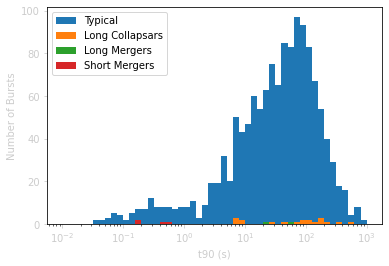

There are 20 known long collapsars, 2 known long mergers, 4 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in Sample 0.
There are 1371 bursts in total


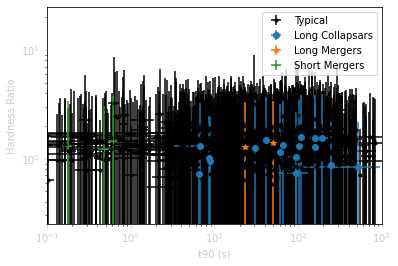

In [57]:
##Sample 0 Diagnositics##
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
actually_valid_fluences=[]
nbins=51
#
#time to kneecap the data
#sample_0_data_b=sample_0_data[:-2]
valid_fluences=swift_fluences.drop(index=tiny_removals[:-2])
actually_valid_mask=np.isin(valid_fluences.index, (sample_0_data.index))
actually_valid_fluences=valid_fluences[actually_valid_mask]
fluence_mask=np.isin(actually_valid_fluences[' 25_50kev '], (" N/A", " N/A ", 0), \
                     invert=True)
fluence_available_swift_data=sample_0_data[fluence_mask]
good_fluences=valid_fluences[fluence_mask]
half_flu_mask=np.isin(good_fluences[' 25_50kev_low '], (" N/A", " N/A ", 0), invert=True)
almost_err_fluences=good_fluences[half_flu_mask]
other_flu_mask=np.isin(almost_err_fluences[' 25_50kev_hi '], (" N/A", " N/A ", 0), invert=True)
complete_err_fluences=almost_err_fluences[other_flu_mask]
lc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Collapsars"])
lc_edited_swift_data=fluence_available_swift_data[lc_mask]
for i in lc_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        long_collapsar_HR=np.append(long_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        long_collapsar_HR=np.NaN
    long_collapsar_t90=np.append(long_collapsar_t90, float(lc_edited_swift_data.at[i, \
                                                                '     T90      ']))
    long_collapsar_HR_err=np.append(long_collapsar_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
long_collapsar_HR_err=long_collapsar_HR_err[1:]
long_collapsar_t90_err=np.where(lc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lc_edited_swift_data['   T90_err    '], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])

sc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Collapsars"])
sc_edited_swift_data=fluence_available_swift_data[sc_mask]
for i in sc_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        short_collapsar_HR=np.append(short_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        short_collapsar_HR=np.NaN
    short_collapsar_t90=np.append(short_collapsar_t90, float(sc_edited_swift_data.at[i, \
                                                                '     T90      ']))
    short_collapsar_HR_err=np.append(short_collapsar_HR_err, \
                                     [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
short_collapsar_HR_err=short_collapsar_HR_err[1:]
short_collapsar_t90_err=np.where(sc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sc_edited_swift_data['   T90_err    '], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Mergers"])
lm_edited_swift_data=fluence_available_swift_data[lm_mask]
for i in lm_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        long_merger_HR=np.append(long_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        long_merger_HR=np.NaN
    long_merger_t90=np.append(long_merger_t90, float(lm_edited_swift_data.at[i, \
                                                                '     T90      ']))
    long_merger_HR_err=np.append(long_merger_HR_err, \
                                 [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
long_merger_HR_err=long_merger_HR_err[1:]
long_merger_t90_err=np.where(lm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lm_edited_swift_data['   T90_err    '], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Mergers"])
sm_edited_swift_data=fluence_available_swift_data[sm_mask]
for i in sm_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        short_merger_HR=np.append(short_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        short_merger_HR=np.NaN
    short_merger_t90=np.append(short_merger_t90, float(sm_edited_swift_data.at[i, \
                                                                '     T90      ']))
    short_merger_HR_err=np.append(short_merger_HR_err, \
                                  [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
short_merger_HR_err=short_merger_HR_err[1:]
short_merger_t90_err=np.where(sm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sm_edited_swift_data['   T90_err    '], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Potentially Exotic"])
exo_edited_swift_data=fluence_available_swift_data[exo_mask]
for i in exo_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        exotic_HR=np.append(exotic_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        exotic_HR=np.NaN
    exotic_t90=np.append(exotic_t90, float(exo_edited_swift_data.at[i, \
                                                                '     T90      ']))
    exotic_HR_err=np.append(exotic_HR_err, [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
exotic_HR_err=exotic_HR_err[1:]
exotic_t90_err=np.where(exo_edited_swift_data[ '   T90_err    '] != 'N/A', \
        exo_edited_swift_data['   T90_err    '], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_edited_swift_data=fluence_available_swift_data[~(lm_mask|lc_mask|sm_mask|sc_mask|\
                                                         exo_mask)]
for i in typical_edited_swift_data.index.to_list():
    if valid_fluences.at[i, ' 50_100kev '] != 'N/A' and \
    valid_fluences.at[i, ' 50_100kev '] != ' N/A ':
        typical_HR=np.append(typical_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    else:
        typical_HR=np.append(typical_HR, np.NaN)
    if typical_edited_swift_data.at[i, '     T90      '] != 'N/A' and \
    typical_edited_swift_data.at[i, '     T90      '] != ' N/A ' and \
    typical_edited_swift_data.at[i, '     T90      '] != '     N/A      ':
        typical_t90=np.append(typical_t90, float(typical_edited_swift_data.at[i, \
                                                                '     T90      ']))
    else:
        typical_t90= np.append(typical_t90, np.NaN)
    typical_HR_err=np.append(typical_HR_err, [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
typical_HR_err=typical_HR_err[1:]
typical_t90_err=np.where(typical_edited_swift_data[ '   T90_err    '] != 'N/A', \
        typical_edited_swift_data['   T90_err    '], 0)
typical_t90_err=np.where(typical_edited_swift_data[ '   T90_err    '] != ' N/A ', \
        typical_edited_swift_data['   T90_err    '], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
plt.hist(long_merger_t90, bins=bins)
# plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 0.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {} bursts in total'.format(np.count_nonzero(~np.isnan(long_collapsar_t90))\
        +np.count_nonzero(~np.isnan(long_merger_t90))+\
        np.count_nonzero(~np.isnan(short_merger_t90))+\
        np.count_nonzero(~np.isnan(short_collapsar_t90))+\
        np.count_nonzero(~np.isnan(exotic_t90))+np.count_nonzero(~np.isnan(typical_t90))))
plt.errorbar(x=typical_t90, y=typical_HR, yerr=np.transpose(typical_HR_err), \
             xerr=typical_t90_err, marker=".", color='k', ls='none')
plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR, \
             yerr=np.transpose(long_collapsar_HR_err), xerr=long_collapsar_t90_err,\
             marker="o", ls='none')
plt.errorbar(x=long_merger_t90, y=long_merger_HR, yerr=np.transpose(long_merger_HR_err),\
             xerr=long_merger_t90_err, marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
#              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=short_merger_HR, yerr=np.transpose(short_merger_HR_err), \
             xerr=short_merger_t90_err, marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.1, 1000, 0.25, 25])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()

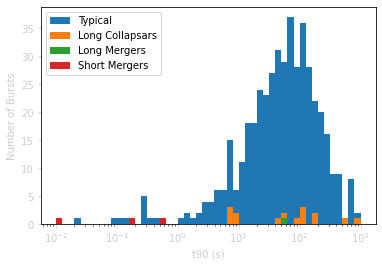

There are 16 known long collapsars, 1 known long mergers, 3 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in Sample 1.
There are 416 bursts in total


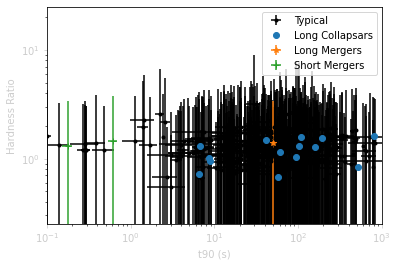

0.02400002

In [58]:
##Sample 1 Diagnositics##
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
nbins=51
#
valid_fluences=swift_fluences.drop(index=removals[:-2])
fluence_mask=np.isin(valid_fluences[' 25_50kev '], (" N/A", " N/A ", 0), invert=True)
fluence_available_swift_data=edited_swift_data[fluence_mask]
good_fluences=valid_fluences[fluence_mask]
half_flu_mask=np.isin(good_fluences[' 25_50kev_low '], (" N/A", " N/A ", 0), invert=True)
almost_err_fluences=good_fluences[half_flu_mask]
other_flu_mask=np.isin(almost_err_fluences[' 25_50kev_hi '], (" N/A", " N/A ", 0), invert=True)
complete_err_fluences=almost_err_fluences[other_flu_mask]
lc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Collapsars"])
lc_edited_swift_data=fluence_available_swift_data[lc_mask]
for i in lc_edited_swift_data.index.to_list():
    long_collapsar_HR=np.append(long_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_collapsar_t90=np.append(long_collapsar_t90, float(lc_edited_swift_data.at[i, \
                                                                '     T90      ']))
    long_collapsar_HR_err=np.append(long_collapsar_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
long_collapsar_HR_err=long_collapsar_HR_err[1:]
long_collapsar_t90_err=np.where(lc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lc_edited_swift_data['   T90_err    '], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])

sc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Collapsars"])
sc_edited_swift_data=fluence_available_swift_data[sc_mask]
for i in sc_edited_swift_data.index.to_list():
    short_collapsar_HR=np.append(short_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_collapsar_t90=np.append(short_collapsar_t90, float(sc_edited_swift_data.at[i, \
                                                                '     T90      ']))
    short_collapsar_HR_err=np.append(short_collapsar_HR_err, \
                                     [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
short_collapsar_HR_err=short_collapsar_HR_err[1:]
short_collapsar_t90_err=np.where(sc_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sc_edited_swift_data['   T90_err    '], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Mergers"])
lm_edited_swift_data=fluence_available_swift_data[lm_mask]
for i in lm_edited_swift_data.index.to_list():
    long_merger_HR=np.append(long_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_merger_t90=np.append(long_merger_t90, float(lm_edited_swift_data.at[i, \
                                                                '     T90      ']))
    long_merger_HR_err=np.append(long_merger_HR_err, \
                                 [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
long_merger_HR_err=long_merger_HR_err[1:]
long_merger_t90_err=np.where(lm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        lm_edited_swift_data['   T90_err    '], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Mergers"])
sm_edited_swift_data=fluence_available_swift_data[sm_mask]
for i in sm_edited_swift_data.index.to_list():
    short_merger_HR=np.append(short_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_merger_t90=np.append(short_merger_t90, float(sm_edited_swift_data.at[i, \
                                                                '     T90      ']))
    short_merger_HR_err=np.append(short_merger_HR_err, \
                                  [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
short_merger_HR_err=short_merger_HR_err[1:]
short_merger_t90_err=np.where(sm_edited_swift_data[ '   T90_err    '] != 'N/A', \
        sm_edited_swift_data['   T90_err    '], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Potentially Exotic"])
exo_edited_swift_data=fluence_available_swift_data[exo_mask]
for i in exo_edited_swift_data.index.to_list():
    exotic_HR=np.append(exotic_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    exotic_t90=np.append(exotic_t90, float(exo_edited_swift_data.at[i, \
                                                                '     T90      ']))
    exotic_HR_err=np.append(exotic_HR_err, [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
exotic_HR_err=exotic_HR_err[1:]
exotic_t90_err=np.where(exo_edited_swift_data[ '   T90_err    '] != 'N/A', \
        exo_edited_swift_data['   T90_err    '], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_edited_swift_data=fluence_available_swift_data[~(lm_mask|lc_mask|sm_mask|sc_mask|\
                                                         exo_mask)]
for i in typical_edited_swift_data.index.to_list():
    typical_HR=np.append(typical_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    typical_t90=np.append(typical_t90, float(typical_edited_swift_data.at[i, \
                                                                '     T90      ']))
    typical_HR_err=np.append(typical_HR_err, [swift_error_calculator(i, valid_fluences)], \
                                   axis=0)
typical_HR_err=typical_HR_err[1:]
typical_t90_err=np.where(typical_edited_swift_data[ '   T90_err    '] != 'N/A', \
        typical_edited_swift_data['   T90_err    '], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
plt.hist(long_merger_t90, bins=bins)
#plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
#plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 1.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {} bursts in total'.format(np.count_nonzero(~np.isnan(long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(long_merger_HR))+\
        np.count_nonzero(~np.isnan(short_merger_HR))+\
        np.count_nonzero(~np.isnan(short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(exotic_HR))+np.count_nonzero(~np.isnan(typical_HR))))
plt.errorbar(x=typical_t90, y=typical_HR, \
             yerr=np.transpose(typical_HR_err), \
             xerr=typical_t90_err, \
             marker=".", color='k', ls='none')
plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR, \
#              yerr=np.transpose(long_collapsar_HR_err), xerr=long_collapsar_t90_err,\
             marker="o", ls='none')
plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
             yerr=np.transpose(long_merger_HR_err),\
             xerr=long_merger_t90_err, \
             marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
#              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=short_merger_HR, \
             yerr=np.transpose(short_merger_HR_err), \
             xerr=short_merger_t90_err, \
             marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.1, 1000, 0.25, 25])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()
min(typical_t90)

<ipython-input-85-42d7ffe48694>:151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
<ipython-input-85-42d7ffe48694>:153: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  high_HR=integrate.quad(lambda x: power_law(x, p_1), \


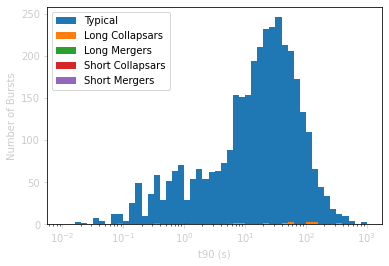

There are 12 known long collapsars, 1 known long mergers, 2 known short mergers, 1 known short collapsars, and 0 known exotic GRBs in Sample 2.
There are 2311/3527 bursts in total


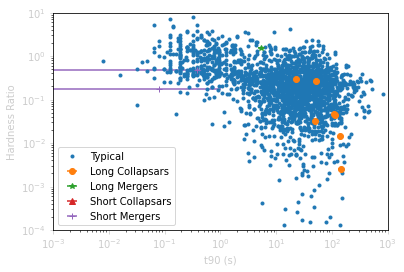

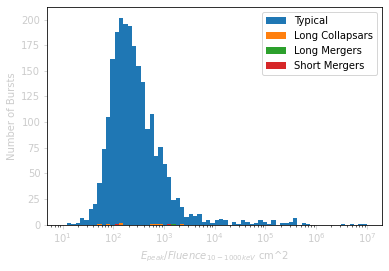

In [88]:
##Sample 2 Diagnositics##
#typical_edited_fermi_data=fermi_data
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
typical_Epeak_over_s=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
long_merger_Epeak_over_s=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
short_merger_Epeak_over_s=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
long_collapsar_Epeak_over_s=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
short_collapsar_Epeak_over_s=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
exotic_Epeak_over_s=[]
nbins=51
lc_mask=np.isin(sample_2_data['name        '], Fermi_Precursors["Long Collapsars"])
lc_sample_2_data=sample_2_data[lc_mask]
for i in lc_sample_2_data.index.to_list():
    long_collapsar_HR=np.append(long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_collapsar_t90=np.append(long_collapsar_t90, float(sample_2_data.at[i, 't90     ']))
    long_collapsar_Epeak_over_s=np.append(long_collapsar_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
long_collapsar_t90_err=np.where(lc_sample_2_data['t90_error'] != 'N/A', \
        lc_sample_2_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
sc_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Short Collapsars"])
sc_sample_2_data=sample_2_data[sc_mask]
for i in sc_sample_2_data.index.to_list():
    short_collapsar_HR=np.append(short_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_collapsar_t90=np.append(short_collapsar_t90, \
                                  float(sample_2_data.at[i, 't90     ']))
    short_collapsar_Epeak_over_s=np.append(short_collapsar_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
short_collapsar_t90_err=np.where(sc_sample_2_data['t90_error'] != 'N/A', \
        sc_sample_2_data['t90_error'], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Long Mergers"])
lm_sample_2_data=sample_2_data[lm_mask]
for i in lm_sample_2_data.index.to_list():
    long_merger_HR=np.append(long_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    long_merger_t90=np.append(long_merger_t90, float(sample_2_data.at[i, 't90     ']))
    long_merger_Epeak_over_s=np.append(long_merger_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
long_merger_t90_err=np.where(lm_sample_2_data['t90_error'] != 'N/A', \
        lm_sample_2_data['t90_error'], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Short Mergers"])
sm_sample_2_data=sample_2_data[sm_mask]
for i in sm_sample_2_data.index.to_list():
    short_merger_HR=np.append(short_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    short_merger_t90=np.append(short_merger_t90, float(sample_2_data.at[i, 't90     ']))
    short_merger_Epeak_over_s=np.append(short_merger_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
short_merger_t90_err=np.where(sm_sample_2_data['t90_error'] != 'N/A', \
        sm_sample_2_data['t90_error'], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(sample_2_data['name        '], \
                Fermi_Precursors["Potentially Exotic"])
exo_sample_2_data=sample_2_data[exo_mask]
for i in exo_sample_2_data.index.to_list():
    exotic_HR=np.append(exotic_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    exotic_t90=np.append(exotic_t90, float(sample_2_data.at[i, 't90     ']))
    exotic_Epeak_over_s=np.append(exotic_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
exotic_t90_err=np.where(exo_sample_2_data['t90_error'] != 'N/A', \
        exo_sample_2_data['t90_error'], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_sample_2_data=sample_2_data[~(lm_mask|lc_mask|sm_mask|sc_mask|exo_mask)]
for i in typical_sample_2_data.index.to_list():
    typical_HR=np.append(typical_HR, Fermi_HR_func(sample_2_data, \
                                sample_2_data.at[i, 'flnc_best_fitting_model'], i))
    typical_t90=np.append(typical_t90, float(typical_sample_2_data.at[i, 't90     ']))
    typical_Epeak_over_s=np.append(typical_Epeak_over_s, \
                        getting_the_GBM_E_peak(sample_2_data, \
                            sample_2_data.at[i, 'flnc_best_fitting_model'], i))
typical_t90_err=np.where(typical_sample_2_data['t90_error'] != 'N/A', \
        typical_sample_2_data['t90_error'], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
plt.hist(long_merger_t90, bins=bins)
plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars',\
            'Short Mergers'])#, 'Exotic'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 2.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(~np.isnan(long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(long_merger_HR))+\
        np.count_nonzero(~np.isnan(short_merger_HR))+\
        np.count_nonzero(~np.isnan(short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(exotic_HR))+np.count_nonzero(~np.isnan(typical_HR)), \
                                              len(sample_2_data)))
plt.errorbar(x=typical_t90, y=typical_HR,\
#              yerr=np.transpose(typical_HR_err),\
#              xerr=typical_t90_err, \
             marker=".", ls='none')
plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR, \
#              yerr=np.transpose(long_collapsar_HR_err), \
             xerr=long_collapsar_t90_err,\
             marker="o",ls='none')
plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
#              yerr=np.transpose(long_merger_HR_err),\
             xerr=long_merger_t90_err,\
             marker="*", ls='none')
plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
#              yerr=np.transpose(short_collapsar_HR_err),\
             xerr=short_collapsar_t90_err,\
             marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=short_merger_HR, \
#              yerr=np.transpose(short_merger_HR_err), \
             xerr=short_merger_t90_err, \
             marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.001, 1000, 1e-4, 10])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers', 'Short Collapsars', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()

new_bins=np.logspace(np.log10(10),np.log10(10**7), 71)
plt.hist(typical_Epeak_over_s, bins=new_bins)
plt.hist(long_collapsar_Epeak_over_s, bins=new_bins)
plt.hist(long_merger_Epeak_over_s, bins=new_bins)
# plt.hist(short_collapsar_Epeak_over_s, bins=new_bins)
plt.hist(short_merger_Epeak_over_s, bins=new_bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical', 'Long Collapsars', 'Long Mergers',\
            'Short Mergers'])#, 'Exotic'])
plt.xlabel(r"$E_{peak}$/$Fluence_{10-1000keV}$ cm^2", color="0.8")
plt.ylabel("Number of Bursts", color="0.8")
plt.show()

/Users/nnuessle/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
<ipython-input-33-c0140a6dc05e>:151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
<ipython-input-33-c0140a6dc05e>:153: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  high_HR=integrate.quad(lambda x: power_law(x, p_1), \


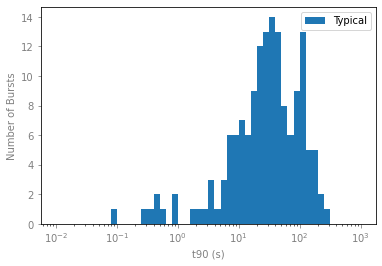

There are 0 known long collapsars, 0 known long mergers, 0 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in Sample 3.
There are 106/153 bursts in total


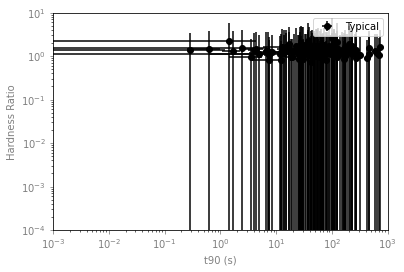

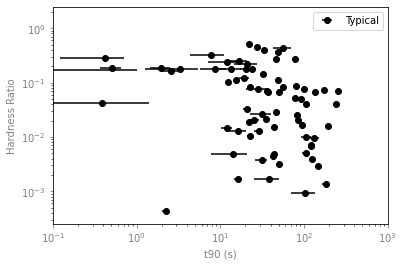

In [60]:
##Sample 3 Diagnositics##
#typical_edited_fermi_data=fermi_data
swift_typical_HR=[]
swift_typical_HR_err=np.zeros((1,2))
fermi_typical_HR=[]
fermi_typical_HR_err=np.zeros((1,2))
swift_typical_t90=[]
swift_typical_t90_err=[]
typical_t90=[]
typical_t90_err=[]
swift_long_merger_HR=[]
swift_long_merger_HR_err=np.zeros((1,2))
fermi_long_merger_HR=[]
fermi_long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
swift_short_merger_HR=[]
swift_short_merger_HR_err=np.zeros((1,2))
fermi_short_merger_HR=[]
fermi_short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
swift_long_collapsar_HR=[]
swift_long_collapsar_HR_err=np.zeros((1,2))
fermi_long_collapsar_HR=[]
fermi_long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
swift_long_collapsar_t90=[]
swift_long_collapsar_t90_err=[]
swift_short_collapsar_HR=[]
swift_short_collapsar_HR_err=np.zeros((1,2))
fermi_short_collapsar_HR=[]
fermi_short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
swift_exotic_HR=[]
swift_exotic_HR_err=np.zeros((1,2))
fermi_exotic_HR=[]
fermi_exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
nbins=51
lc_mask=np.isin(sample_3_data['name'], \
                Fermi_Precursors["Long Collapsars"])
lc_sample_3_data=sample_3_data[lc_mask]
for i in lc_sample_3_data.index.to_list():
    if valid_fluences.at[int(sample_3_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_3_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, \
            float(valid_fluences.at[int(sample_3_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_3_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_3_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, np.NaN)
        swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, np.NaN)
    if edited_swift_data.at[int(sample_3_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, \
            edited_swift_data.at[int(sample_3_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, 0)
    fermi_long_collapsar_HR=np.append(fermi_long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_3_data.at[i, 'Spectral Model'], \
                                            int(sample_3_data.at[i, 'Fermi row'])))
    long_collapsar_t90=np.append(long_collapsar_t90, \
                                 float(lc_sample_3_data.at[i, 't90']))
    swift_long_collapsar_HR_err=np.append(swift_long_collapsar_HR_err,\
        [swift_error_calculator(int(sample_3_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
long_collapsar_t90_err=np.where(lc_sample_3_data['t90_error'] != 'N/A', \
        lc_sample_3_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
        
sc_mask=np.isin(sample_3_data['name'], \
                Fermi_Precursors["Short Collapsars"])
lm_mask=np.isin(sample_3_data['name'], \
                Fermi_Precursors["Long Mergers"])
sm_mask=np.isin(sample_3_data['name'], \
                Fermi_Precursors["Short Mergers"])
exo_mask=np.isin(sample_3_data['name'], \
                Fermi_Precursors["Potentially Exotic"])
typical_sample_3_data=sample_3_data[~(lm_mask|lc_mask|sm_mask|sc_mask|exo_mask)]
for i in typical_sample_3_data.index.to_list():
    if valid_fluences.at[int(sample_3_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
    and valid_fluences.at[int(sample_3_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_typical_HR=np.append(swift_typical_HR, \
            float(valid_fluences.at[int(sample_3_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_3_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_typical_t90=np.append(swift_typical_t90, float(edited_swift_data.at[\
                                        int(sample_3_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_typical_HR=np.append(swift_typical_HR, np.NaN)
        swift_typical_t90=np.append(swift_typical_t90, np.NaN)
    if edited_swift_data.at[int(sample_3_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_typical_t90_err = np.append(swift_typical_t90_err, \
            edited_swift_data.at[int(sample_3_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_typical_t90_err = np.append(swift_typical_t90_err, 0)
    fermi_typical_HR=np.append(fermi_typical_HR, Fermi_HR_func(sample_2_data, \
                                sample_3_data.at[i, 'Spectral Model'], \
                                            int(sample_3_data.at[i, 'Fermi row'])))
    typical_t90=np.append(typical_t90, float(typical_sample_3_data.at[i, 't90']))
    
    swift_typical_HR_err=np.append(swift_typical_HR_err, \
        [swift_error_calculator(int(sample_3_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
typical_t90_err=np.where(typical_sample_3_data['t90_error'] != 'N/A', \
        typical_sample_3_data['t90_error'], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
swift_typical_HR_err=swift_typical_HR_err[1:]
swift_long_collapsar_HR_err=swift_long_collapsar_HR_err[1:]
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
# plt.hist(long_collapsar_t90, bins=bins)
# plt.hist(long_merger_t90, bins=bins)
# plt.hist(short_collapsar_t90, bins=bins)
# plt.hist(short_merger_t90, bins=bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical'])#, 'Exotic'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Number of Bursts", color="0.5")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 3.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(\
                                                ~np.isnan(fermi_long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(fermi_long_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(fermi_exotic_HR))+\
                                        np.count_nonzero(~np.isnan(fermi_typical_HR)), \
                                              len(sample_3_data)))
plt.errorbar(x=swift_typical_t90, y=swift_typical_HR, \
             yerr=np.transpose(swift_typical_HR_err), \
             xerr=typical_t90_err, marker="o", color='k', ls='none')
# plt.errorbar(x=swift_long_collapsar_t90, y=swift_long_collapsar_HR, \
#              yerr=np.transpose(swift_long_collapsar_HR_err), \
#              xerr=swift_long_collapsar_t90_err, marker=".", color='k', ls='none')
plt.axis([0.001, 1000, 1e-4, 10])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Hardness Ratio", color="0.5")
plt.show()
plt.errorbar(x=typical_t90, y=fermi_typical_HR,\
#              yerr=np.transpose(typical_HR_err), \
             xerr=typical_t90_err, \
             marker="o", color='k', ls='none')
# plt.errorbar(x=long_collapsar_t90, y=fermi_long_collapsar_HR, \
# #              yerr=np.transpose(long_collapsar_HR_err),
#              xerr=long_collapsar_t90_err,\
#              marker="o", ls='none')
# plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
# #              yerr=np.transpose(long_merger_HR_err), xerr=long_merger_t90_err,\
#              marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
# #              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
# plt.errorbar(x=short_merger_t90, y=short_merger_HR, \
# #              yerr=np.transpose(short_merger_HR_err), xerr=short_merger_t90_err, \
#              marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.1, 1000, 0.00025, 2.5])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Hardness Ratio", color="0.5")
plt.show()

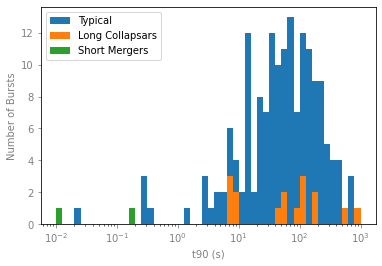

There are 16 known long collapsars, 0 known long mergers, 2 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in Sample 4.
There are 164/184 bursts in total


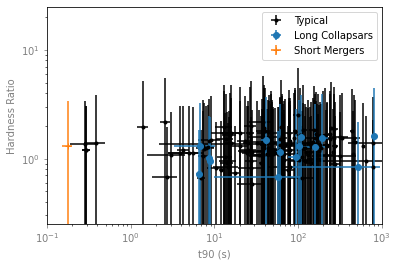

In [63]:
##Sample 4 Diagnositics##
typical_HR=[]
typical_HR_err=np.zeros((1,2))
typical_t90=[]
typical_t90_err=[]
long_merger_HR=[]
long_merger_HR_err=np.zeros((1,2))
long_merger_t90=[]
long_merger_t90_err=[]
short_merger_HR=[]
short_merger_HR_err=np.zeros((1,2))
short_merger_t90=[]
short_merger_t90_err=[]
long_collapsar_HR=[]
long_collapsar_HR_err=np.zeros((1,2))
long_collapsar_t90=[]
long_collapsar_t90_err=[]
short_collapsar_HR=[]
short_collapsar_HR_err=np.zeros((1,2))
short_collapsar_t90=[]
short_collapsar_t90_err=[]
exotic_HR=[]
exotic_HR_err=np.zeros((1,2))
exotic_t90=[]
exotic_t90_err=[]
nbins=51
#
valid_fluences=swift_fluences.drop(index=removals[:-2])
actually_valid_mask=np.isin(valid_fluences.index, (redshift_swift_data.index))
actually_valid_fluences=valid_fluences[actually_valid_mask]
fluence_mask=np.isin(actually_valid_fluences[' 25_50kev '], (" N/A", " N/A ", 0), invert=True)
fluence_available_swift_data=redshift_swift_data[fluence_mask]
good_fluences=actually_valid_fluences[fluence_mask]
half_flu_mask=np.isin(good_fluences[' 25_50kev_low '], (" N/A", " N/A ", 0), invert=True)
almost_err_fluences=good_fluences[half_flu_mask]
other_flu_mask=np.isin(almost_err_fluences[' 25_50kev_hi '], (" N/A", " N/A ", 0), invert=True)
complete_err_fluences=almost_err_fluences[other_flu_mask]
lc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Collapsars"])
lc_redshift_swift_data=fluence_available_swift_data[lc_mask]
for i in lc_redshift_swift_data.index.to_list():
    long_collapsar_HR=np.append(long_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_collapsar_t90=np.append(long_collapsar_t90, float(lc_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    long_collapsar_HR_err=np.append(long_collapsar_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
long_collapsar_t90_err=np.where(lc_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        lc_redshift_swift_data['   T90_err    '], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
sc_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Collapsars"])
sc_redshift_swift_data=fluence_available_swift_data[sc_mask]
for i in sc_redshift_swift_data.index.to_list():
    short_collapsar_HR=np.append(short_collapsar_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_collapsar_t90=np.append(short_collapsar_t90, float(sc_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    short_collapsar_HR_err=np.append(short_collapsar_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
short_collapsar_t90_err=np.where(sc_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        sc_redshift_swift_data['   T90_err    '], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Long Mergers"])
lm_redshift_swift_data=fluence_available_swift_data[lm_mask]
for i in lm_redshift_swift_data.index.to_list():
    long_merger_HR=np.append(long_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    long_merger_t90=np.append(long_merger_t90, float(lm_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    long_merger_HR_err=np.append(long_merger_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
long_merger_t90_err=np.where(lm_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        lm_redshift_swift_data['   T90_err    '], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Short Mergers"])
sm_redshift_swift_data=fluence_available_swift_data[sm_mask]
for i in sm_redshift_swift_data.index.to_list():
    short_merger_HR=np.append(short_merger_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    short_merger_t90=np.append(short_merger_t90, float(sm_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    short_merger_HR_err=np.append(short_merger_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
short_merger_t90_err=np.where(sm_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        sm_redshift_swift_data['   T90_err    '], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(fluence_available_swift_data[ "GRBname "], \
                Known_Precursors["Potentially Exotic"])
exo_redshift_swift_data=fluence_available_swift_data[exo_mask]
for i in exo_redshift_swift_data.index.to_list():
    exotic_HR=np.append(exotic_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    exotic_t90=np.append(exotic_t90, float(exo_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    exotic_HR_err=np.append(exotic_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
exotic_t90_err=np.where(exo_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        exo_redshift_swift_data['   T90_err    '], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_redshift_swift_data=fluence_available_swift_data[~(lm_mask|lc_mask|sm_mask|sc_mask|\
                                                         exo_mask)]
for i in typical_redshift_swift_data.index.to_list():
    typical_HR=np.append(typical_HR, \
            float(valid_fluences.at[i, ' 50_100kev '])/\
                            float(valid_fluences.at[i, ' 25_50kev ']))
    typical_t90=np.append(typical_t90, float(typical_redshift_swift_data.at[i, \
                                                                '     T90      ']))
    typical_HR_err=np.append(typical_HR_err, \
                                    [swift_error_calculator(i, valid_fluences)], axis=0)
typical_t90_err=np.where(typical_redshift_swift_data[ '   T90_err    '] != 'N/A', \
        typical_redshift_swift_data['   T90_err    '], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
long_collapsar_HR_err=long_collapsar_HR_err[1:]
short_collapsar_HR_err=short_collapsar_HR_err[1:]
long_merger_HR_err=long_merger_HR_err[1:]
short_merger_HR_err=short_merger_HR_err[1:]
exotic_HR_err=exotic_HR_err[1:]
typical_HR_err=typical_HR_err[1:]

bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
plt.hist(long_collapsar_t90, bins=bins)
# plt.hist(long_merger_t90, bins=bins)
#plt.hist(short_collapsar_t90, bins=bins)
plt.hist(short_merger_t90, bins=bins)
#plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical', 'Long Collapsars', \
            'Short Mergers'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Number of Bursts", color="0.5")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 4.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(~np.isnan(long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(long_merger_HR))+\
        np.count_nonzero(~np.isnan(short_merger_HR))+\
        np.count_nonzero(~np.isnan(short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(exotic_HR))+np.count_nonzero(~np.isnan(typical_HR)), \
                                              len(sample_4_data)))
plt.errorbar(x=typical_t90, y=typical_HR, yerr=np.transpose(typical_HR_err), \
             xerr=typical_t90_err, marker=".", color='k', ls='none')
plt.errorbar(x=long_collapsar_t90, y=long_collapsar_HR, \
             yerr=np.transpose(long_collapsar_HR_err), xerr=long_collapsar_t90_err,\
             marker="o", ls='none')
# plt.errorbar(x=long_merger_t90, y=long_merger_HR, yerr=np.transpose(long_merger_HR_err),\
#              xerr=long_merger_t90_err, marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
#              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
plt.errorbar(x=short_merger_t90, y=short_merger_HR, yerr=np.transpose(short_merger_HR_err), \
             xerr=short_merger_t90_err, marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.1, 1000, 0.25, 25])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical', 'Long Collapsars', 'Short Mergers'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Hardness Ratio", color="0.5")
plt.show()

<ipython-input-33-c0140a6dc05e>:151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  low_HR=integrate.quad(lambda x: power_law(x, p_1), low_e_range[0], \
<ipython-input-33-c0140a6dc05e>:153: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  high_HR=integrate.quad(lambda x: power_law(x, p_1), \


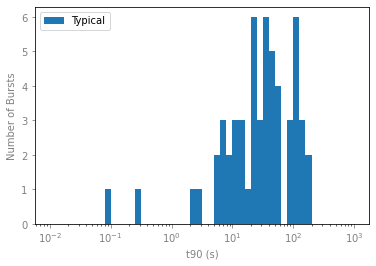

There are 0 known long collapsars, 0 known long mergers, 0 known short mergers, 0 known short collapsars, and 0 known exotic GRBs in Sample 6.
There are 43/56 bursts in total


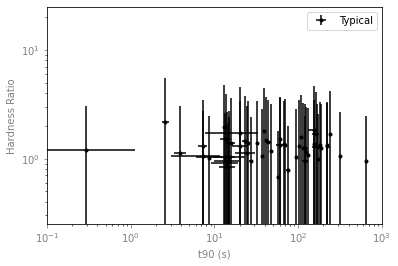

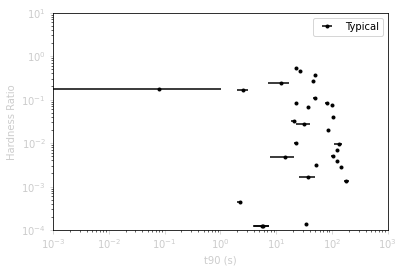

In [64]:
##Sample 6 Diagnositics##
#typical_edited_fermi_data=fermi_data
swift_typical_HR=[]
swift_typical_HR_err=np.zeros((1,2))
fermi_typical_HR=[]
fermi_typical_HR_err=np.zeros((1,2))
swift_typical_t90=[]
swift_typical_t90_err=[]
typical_t90=[]
typical_t90_err=[]
swift_long_merger_HR=[]
swift_long_merger_HR_err=np.zeros((1,2))
fermi_long_merger_HR=[]
femri_long_merger_HR_err=np.zeros((1,2))
swift_long_merger_t90=[]
swift_long_merger_t90_err=[]
long_merger_t90=[]
long_merger_t90_err=[]
swift_short_merger_HR=[]
swift_short_merger_HR_err=np.zeros((1,2))
fermi_short_merger_HR=[]
fermi_short_merger_HR_err=np.zeros((1,2))
swift_short_merger_t90=[]
short_merger_t90_err=[]
short_merger_t90=[]
short_merger_t90_err=[]
swift_long_collapsar_HR=[]
swift_long_collapsar_HR_err=np.zeros((1,2))
fermi_long_collapsar_HR=[]
fermi_long_collapsar_HR_err=np.zeros((1,2))
swift_long_collapsar_t90=[]
swift_long_collapsar_t90_err=[]
long_collapsar_t90=[]
long_collapsar_t90_err=[]
swift_short_collapsar_HR=[]
swift_short_collapsar_HR_err=np.zeros((1,2))
fermi_short_collapsar_HR=[]
fermi_short_collapsar_HR_err=np.zeros((1,2))
swift_short_collapsar_t90=[]
swift_short_collapsar_t90_err=[]
short_collapsar_t90=[]
short_collapsar_t90_err=[]
swift_exotic_HR=[]
swift_exotic_HR_err=np.zeros((1,2))
fermi_exotic_HR=[]
fermi_exotic_HR_err=np.zeros((1,2))
swift_exotic_t90=[]
swift_exotic_t90_err=[]
exotic_t90=[]
exotic_t90_err=[]
nbins=51
#
lc_mask=np.isin(sample_6_data['name'], \
                Fermi_Precursors["Long Collapsars"])
lc_sample_6_data=sample_6_data[lc_mask]
for i in lc_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_long_collapsar_HR=np.append(swift_long_collapsar_HR, np.NaN)
        swift_long_collapsar_t90=np.append(swift_long_collapsar_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_long_collapsar_t90_err = np.append(swift_long_collapsar_t90_err, 0)
    fermi_long_collapsar_HR=np.append(fermi_long_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    long_collapsar_t90=np.append(long_collapsar_t90, \
                                 float(lc_sample_6_data.at[i, 't90']))
    swift_long_collapsar_HR_err=np.append(swift_long_collapsar_HR_err,\
        [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
long_collapsar_t90_err=np.where(lc_sample_6_data['t90_error'] != 'N/A', \
        lc_sample_6_data['t90_error'], 0)
if len(long_collapsar_t90_err)>0:
    for j in range(0, len(long_collapsar_t90_err)):
        long_collapsar_t90_err[j]=float(long_collapsar_t90_err[j])
sc_mask=np.isin(sample_6_data['name'], \
                Fermi_Precursors["Short Collapsars"])
sc_sample_6_data=sample_6_data[sc_mask]
for i in sc_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_short_collapsar_HR=np.append(swift_short_collapsar_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_short_collapsar_t90=np.append(swift_short_collapsar_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_short_collapsar_HR=np.append(swift_short_collapsar_HR, np.NaN)
        swift_short_collapsar_t90=np.append(swift_short_collapsar_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_short_collapsar_t90_err = np.append(swift_short_collapsar_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_short_collapsar_t90_err = np.append(swift_short_collapsar_t90_err, 0)
    fermi_short_collapsar_HR=np.append(fermi_short_collapsar_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    short_collapsar_t90=np.append(short_collapsar_t90, \
                                 float(sc_sample_6_data.at[i, 't90']))
    swift_short_collapsar_HR_err=np.append(swift_short_collapsar_HR_err,\
        [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
short_collapsar_t90_err=np.where(sc_sample_6_data['t90_error'] != 'N/A', \
        sc_sample_6_data['t90_error'], 0)
if len(short_collapsar_t90_err)>0:
    for j in range(0, len(short_collapsar_t90_err)):
        short_collapsar_t90_err[j]=float(short_collapsar_t90_err[j])
lm_mask=np.isin(sample_6_data['name'], \
                Fermi_Precursors["Long Mergers"])
lm_sample_6_data=sample_6_data[lm_mask]
for i in lm_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_long_merger_HR=np.append(swift_long_merger_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_long_merger_t90=np.append(swift_long_merger_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_long_merger_HR=np.append(swift_long_merger_HR, np.NaN)
        swift_long_merger_t90=np.append(swift_long_merger_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_long_merger_t90_err = np.append(swift_long_merger_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_long_merger_t90_err = np.append(swift_long_merger_t90_err, 0)
    fermi_long_merger_HR=np.append(fermi_long_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    long_merger_t90=np.append(long_merger_t90, \
                                 float(lm_sample_6_data.at[i, 't90']))
    swift_long_merger_HR_err=np.append(swift_long_merger_HR_err,\
        [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
long_merger_t90_err=np.where(lm_sample_6_data['t90_error'] != 'N/A', \
        lm_sample_6_data['t90_error'], 0)
if len(long_merger_t90_err)>0:
    for j in range(0, len(long_merger_t90_err)):
        long_merger_t90_err[j]=float(long_merger_t90_err[j])
sm_mask=np.isin(sample_6_data['name'], \
                Fermi_Precursors["Short Mergers"])
sm_sample_6_data=sample_6_data[sm_mask]
for i in sm_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_short_merger_HR=np.append(swift_short_merger_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_short_merger_t90=np.append(swift_short_merger_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_short_merger_HR=np.append(swift_short_merger_HR, np.NaN)
        swift_short_merger_t90=np.append(swift_short_merger_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_short_merger_t90_err = np.append(swift_short_merger_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_short_merger_t90_err = np.append(swift_short_merger_t90_err, 0)
    fermi_short_merger_HR=np.append(fermi_short_merger_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    short_merger_t90=np.append(short_merger_t90, \
                                 float(sm_sample_6_data.at[i, 't90']))
    swift_short_merger_HR_err=np.append(swift_short_merger_HR_err,\
        [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
short_merger_t90_err=np.where(sm_sample_6_data['t90_error'] != 'N/A', \
        sm_sample_6_data['t90_error'], 0)
if len(short_merger_t90_err)>0:
    for j in range(0, len(short_merger_t90_err)):
        short_merger_t90_err[j]=float(short_merger_t90_err[j])
exo_mask=np.isin(sample_6_data['name'], \
                Fermi_Precursors["Potentially Exotic"])
exo_sample_6_data=sample_6_data[exo_mask]
for i in exo_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_exotic_HR=np.append(swift_exotic_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_exotic_t90=np.append(swift_exotic_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_exotic_HR=np.append(swift_exotic_HR, np.NaN)
        swift_exotic_t90=np.append(swift_exotic_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_exotic_t90_err = np.append(swift_exotic_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_exotic_t90_err = np.append(swift_exotic_t90_err, 0)
    fermi_exotic_HR=np.append(fermi_exotic_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    exotic_t90=np.append(exotic_t90, \
                                 float(exo_sample_6_data.at[i, 't90']))
    swift_exotic_HR_err=np.append(swift_exotic_HR_err,\
         [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
exotic_t90_err=np.where(exo_sample_6_data['t90_error'] != 'N/A', \
        exo_sample_6_data['t90_error'], 0)
if len(exotic_t90_err)>0:
    for j in range(0, len(exotic_t90_err)):
        exotic_t90_err[j]=float(exotic_t90_err[j])
typical_sample_6_data=sample_6_data[~(lm_mask|lc_mask|sm_mask|sc_mask|exo_mask)]
for i in typical_sample_6_data.index.to_list():
    if valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 25_50kev '] != ' N/A '\
        and valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),' 25_50kev '] != ' N/A ':
        swift_typical_HR=np.append(swift_typical_HR, \
            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']), ' 50_100kev '])/\
                            float(valid_fluences.at[int(sample_6_data.at[i, 'Swift row']),\
                                                    ' 25_50kev ']))
        swift_typical_t90=np.append(swift_typical_t90, \
                                           float(edited_swift_data.at[\
                                        int(sample_6_data.at[i, 'Swift row']), \
                                                                    '     T90      ']))
    else: 
        swift_typical_HR=np.append(swift_typical_HR, np.NaN)
        swift_typical_t90=np.append(swift_typical_t90, np.NaN)
    if edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '] !=\
    'N/A':
        swift_typical_t90_err = np.append(swift_typical_t90_err, \
            edited_swift_data.at[int(sample_6_data.at[i, 'Swift row']), '   T90_err    '])
    else: 
        swift_typical_t90_err = np.append(swift_typical_t90_err, 0)
    fermi_typical_HR=np.append(fermi_typical_HR, Fermi_HR_func(sample_2_data, \
                                sample_6_data.at[i, 'Spectral Model'], \
                                            int(sample_6_data.at[i, 'Fermi row'])))
    typical_t90=np.append(typical_t90, \
                                 float(typical_sample_6_data.at[i, 't90']))
    swift_typical_HR_err=np.append(swift_typical_HR_err,\
        [swift_error_calculator(int(sample_6_data.at[i, 'Swift row']), valid_fluences)], \
                                   axis=0)
typical_t90_err=np.where(typical_sample_6_data['t90_error'] != 'N/A', \
        typical_sample_6_data['t90_error'], 0)
if len(typical_t90_err)>0:
    for j in range(0, len(typical_t90_err)):
        typical_t90_err[j]=float(typical_t90_err[j])
swift_long_merger_HR_err=swift_long_merger_HR_err[1:]
swift_long_collapsar_HR_err=swift_long_collapsar_HR_err[1:]
swift_short_merger_HR_err=swift_short_merger_HR_err[1:]
swift_short_collapsar_HR_err=swift_short_collapsar_HR_err[1:]
swift_exotic_HR_err=swift_exotic_HR_err[1:]
swift_typical_HR_err=swift_typical_HR_err[1:]
bins=np.logspace(np.log10(0.01),np.log10(1000), nbins)
plt.hist(typical_t90, bins=bins)
# plt.hist(long_collapsar_t90, bins=bins)
# plt.hist(long_merger_t90, bins=bins)
# plt.hist(short_collapsar_t90, bins=bins)
# plt.hist(short_merger_t90, bins=bins)
# plt.hist(exotic_t90, bins=bins)
plt.xscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical'])#, 'Exotic'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Number of Bursts", color="0.5")
plt.show()
print("There are {} known long collapsars, {} known long \
mergers, {} known short mergers, {} known short collapsars, and \
{} known exotic GRBs in Sample 6.".\
format(len(long_collapsar_t90), len(long_merger_t90), \
       len(short_merger_t90), len(short_collapsar_t90), len(exotic_t90)))
print('There are {}/{} bursts in total'.format(np.count_nonzero(\
                                                ~np.isnan(swift_long_collapsar_HR))\
        +np.count_nonzero(~np.isnan(fermi_long_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_merger_HR))+\
        np.count_nonzero(~np.isnan(fermi_short_collapsar_HR))+\
        np.count_nonzero(~np.isnan(fermi_exotic_HR))+\
                                        np.count_nonzero(~np.isnan(fermi_typical_HR)), \
                                              len(sample_6_data)))
plt.errorbar(x=swift_typical_t90, y=swift_typical_HR, \
             yerr=np.transpose(swift_typical_HR_err), \
             xerr=typical_t90_err, marker=".", color='k', ls='none')
plt.errorbar(x=swift_long_collapsar_t90, y=swift_long_collapsar_HR, \
             yerr=np.transpose(swift_long_collapsar_HR_err), \
             xerr=swift_long_collapsar_t90_err, marker=".", color='k', ls='none')
plt.axis([0.1, 1000, 0.25, 25])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.5')
plt.tick_params(axis='y', colors='0.5')
plt.legend(['Typical'])
plt.xlabel("t90 (s)", color="0.5")
plt.ylabel("Hardness Ratio", color="0.5")
plt.show()
plt.errorbar(x=typical_t90, y=fermi_typical_HR,\
#              yerr=np.transpose(typical_HR_err), \
             xerr=typical_t90_err, \
             marker=".", color='k', ls='none')
# plt.errorbar(x=long_collapsar_t90, y=fermi_long_collapsar_HR, \
# #              yerr=np.transpose(long_collapsar_HR_err),
#              xerr=long_collapsar_t90_err,\
#              marker="o", ls='none')
# plt.errorbar(x=long_merger_t90, y=long_merger_HR, \
# #              yerr=np.transpose(long_merger_HR_err), xerr=long_merger_t90_err,\
#              marker="*", ls='none')
# plt.errorbar(x=short_collapsar_t90, y=short_collapsar_HR, \
# #              yerr=np.transpose(short_collapsar_HR_err), xerr=short_collapsar_t90_err,\
#              marker="^", ls='none')
# plt.errorbar(x=short_merger_t90, y=short_merger_HR, \
# #              yerr=np.transpose(short_merger_HR_err), xerr=short_merger_t90_err, \
#              marker="+", ls='none')
# plt.errorbar(x=exotic_t90, y=exotic_HR, yerr=np.transpose(exotic_HR_err), \
#              xerr=exotic_t90_err, marker="o", ls='none')
plt.axis([0.001, 1000, 1e-4, 10])
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='x', colors='0.8')
plt.tick_params(axis='y', colors='0.8')
plt.legend(['Typical'])
plt.xlabel("t90 (s)", color="0.8")
plt.ylabel("Hardness Ratio", color="0.8")
plt.show()

In [50]:
swift_fluences.columns

Index(['GRBname ', ' 25_50kev ', ' 25_50kev_low ', ' 25_50kev_hi ',
       ' 50_100kev ', ' 50_100kev_low ', ' 50_100kev_hi ', ' 15_150kev '],
      dtype='object')